Group Members:
-   Abhijeet Pal (200100107)
-   Kanak Yadav (20D070044)

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from IPython.display import display, Markdown
import tensorflow as tf
from tensorflow import keras
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

# Importing all the libraries used in the assignment

In [88]:
#Inspirations

# https://www.youtube.com/watch?v=M3EZS__Z_XE
# https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb
# https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
# https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05
# https://stackoverflow.com/questions/25239933/how-to-add-a-title-to-each-subplot
# https://www.cns.nyu.edu/pub/eero/wang03b.pdf
# https://stackoverflow.com/questions/57813137/how-to-use-watershed-segmentation-in-opencv-python

# 1. Displaying a few training and testing images and their masks.

In [87]:
paths = [
    'd:\\kanak\\iitb\\sem5\\EE610\\assignments\\MoNuSeg-Training-Data\\Tissue-Images',
    'd:\\kanak\\iitb\\sem5\\EE610\\assignments\\MoNuSeg-Training-Data\\Color-Mask',
    'd:\\kanak\\iitb\\sem5\\EE610\\assignments\\MoNuSeg-Test-Data\\Tissue-Images',
    'd:\\kanak\\iitb\\sem5\\EE610\\assignments\\MoNuSeg-Test-Data\\Color-Mask',
    'd:\\kanak\\iitb\\sem5\\EE610\\assignments\\MoNuSeg-Training-Data\\Binary-Mask',
    'd:\\kanak\\iitb\\sem5\\EE610\\assignments\\MoNuSeg-Test-Data\\Binary-Mask'
    ]

# Loading the paths of Tissue Images, Color Masks, Binary Masks of training and testing data

Training-Data\Tissue-Images

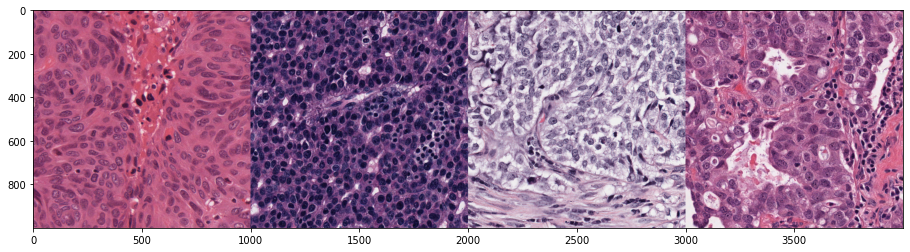

Training-Data\Color-Mask

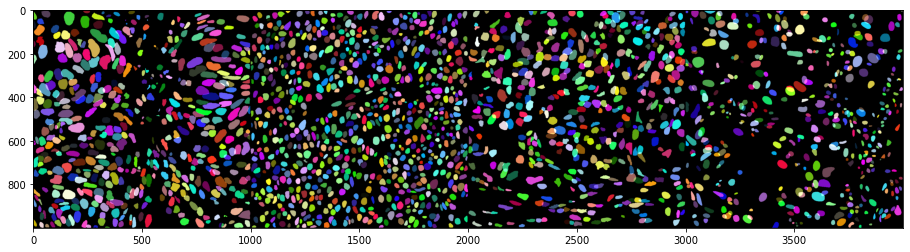

Test-Data\Tissue-Images

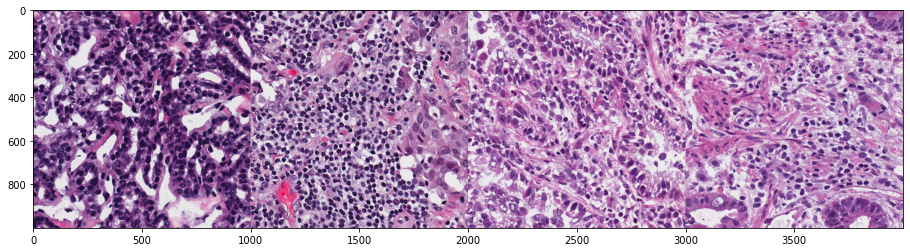

Test-Data\Color-Mask

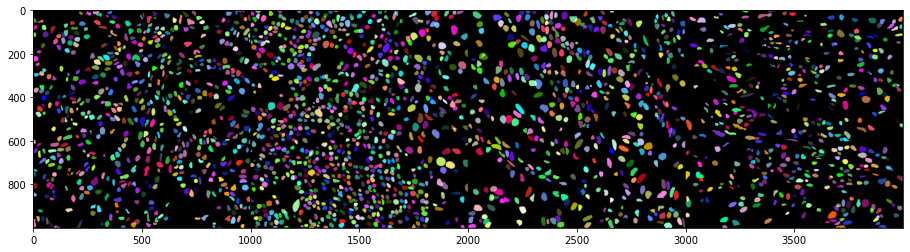

In [5]:
image_ids = []
# Displaying a few training and testing images and their masks
for path in paths[:4]:
    os.chdir(path)
    image_ids.append(os.listdir())
    img = np.concatenate(list(map(plt.imread, image_ids[-1][:4])), 1)
    # Concatenating the images to display parallely
    # sources:
    # https://www.geeksforgeeks.org/os-module-python-examples/
    # https://www.geeksforgeeks.org/change-plot-size-in-matplotlib-python/
    # https://stackoverflow.com/questions/71181673/how-can-i-display-image-data-in-jupyter-notebook-and-control-its-position
    im = plt.figure(figsize=(16, 4))
    plt.imshow(img)
    plt.close()
    display(Markdown(path[45:]))
    display(im.figure)
image_ids = image_ids[::2]
# Storing the testing and training images ids to use in UNet Model

# 2. Coding the UNet

In [6]:
# The below code is modly inspired/copied from 
# https://www.youtube.com/watch?v=M3EZS__Z_XE
# https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

# Defining the Data Generator
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    #Defining the data loading function 
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path[0], id_name)
        mask_path = os.path.join(self.path[1], id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (self.image_size, self.image_size))
                
        ## Reading Masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.image_size, self.image_size))

        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    # Defining the get item function to load images in batches
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Defining building blocks of UNet
# Down Block 
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

# Up Block
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# Defining bottleneck
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
image_size = 512
# Defining number of feature to be learned
def filts(num_filts, num_blocks):
    f = [num_filts]
    for i in range(num_blocks):
        f.append(f[-1]*2)
    return f

# Defining the adjustable architecture of UNet model with variable number of filters and blocks
# The number of filters and blocks needs to be changed in Q5.
def UNet(num_filts=16, num_blocks=4):
    f = filts(num_filts, num_blocks)
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    c, p = [], [inputs]
    for i in range(num_blocks):
        _ = down_block(p[i], f[i])
        c.append(_[0])
        p.append(_[1])
    
    bn = bottleneck(p[-1], f[-1])
    u = bn
    
    for i in range(num_blocks):
        u = up_block(u, c[-i-1], f[-i-1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u)
    model = keras.models.Model(inputs, outputs)
    return model

# 3. Training the Model using Dice Loss and showing Dice Scores

In [8]:
# Defining the custom dice loss function
def dice_loss(y_true, y_pred):
    return 1 - dice_score(y_true, y_pred)

# Defining the dice score metric
def dice_score(y_true, y_pred):
    return 2 * tf.reduce_sum(y_true * y_pred) / ( tf.reduce_sum(y_true**2 + y_pred**2) )

In [9]:
# epoch is number of times the model is trained
epochs = 3
# Batch size is the number of images loaded at a time
batch_size = 6

# Loading the training path, testing path along with the images in respective train_ids and test_ids
train_path = [paths[0], paths[-2]]
train_ids = image_ids[0]

test_path = [paths[2], paths[-1]]
test_ids = image_ids[1]

# Dividing images into training and validation images
train_ids, valid_ids = train_ids[batch_size:], train_ids[:batch_size]

# Generating the training and validation images
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

model = UNet()
# Model with default number of filters (16) and blocks  (4)
model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_score])
# Fitting the images into the model
model.fit(x=train_gen, validation_data=valid_gen, epochs=epochs)

# Save the Weights
model.save_weights("UNetW04112022.h5")

Epoch 1/3
4/4 [==============================] - 100s 25s/step - loss: 0.4854 - dice_score: 0.5146 - val_loss: 0.4268 - val_dice_score: 0.5732
Epoch 2/3
4/4 [==============================] - 95s 24s/step - loss: 0.4675 - dice_score: 0.5325 - val_loss: 0.4151 - val_dice_score: 0.5849
Epoch 3/3
4/4 [==============================] - 94s 24s/step - loss: 0.4470 - dice_score: 0.5530 - val_loss: 0.3932 - val_dice_score: 0.6068


In [10]:
# Calculating the dice score of the predicted images
def calc_dice_score(y, result):
    return [2 * np.sum(y[i] * result[i]) / ( np.sum(y[i]**2 + result[i]**2) ) for i in range(y.shape[0])]


x_val, y_val = valid_gen.__getitem__(0)
result_val = model.predict(x_val)
val_score = calc_dice_score(y_val, result_val)
print('Validation Dice Scores: ', val_score)
# Printing dice scores of the validation images


test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size*2)
x_test, y_test = test_gen.__getitem__(0)
result_test = model.predict(x_test)
test_score = calc_dice_score(y_test, result_test)
print('Testing Dice Scores: ', test_score)
# Printing dice scores of the testing images

1/1 [==============================] - 6s 6s/step
Validation Dice Scores:  [0.5357083171665851, 0.5780239139808259, 0.47303886357605024, 0.43100258707534883, 0.5491960872255229, 0.5424595652815739]
1/1 [==============================] - 11s 11s/step
Testing Dice Scores:  [0.4381989610717172, 0.48251305342239986, 0.4239805637250194, 0.37755900741338855, 0.4916522110840438, 0.46524225132231767, 0.47057399191232463, 0.38359365541587365, 0.45469365644607196, 0.4258305314050816, 0.3762354291963518, 0.30016228422403307]


# 4. Showing a few ouput maps

In [11]:
# Converting the image to a binary map with a variable threshold
def to_binary(prob_map, threshold):
    binary_map = np.zeros_like(prob_map)
    binary_map[prob_map > threshold] = 1
    return binary_map

Validation Images

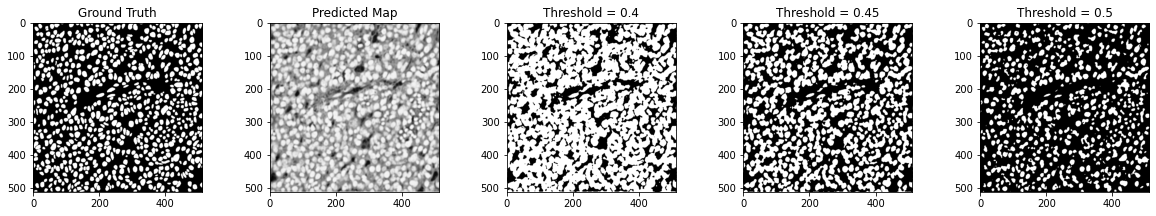

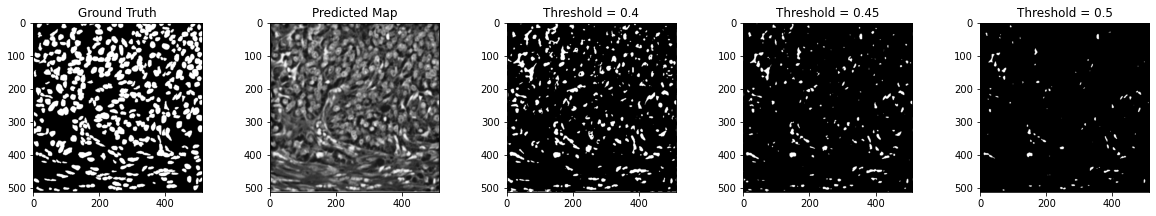

In [12]:
# Displaying the images in the order of 
# Ground Truth, Predicted Map, Threshold = 0.4, Threshold = 0.45 and Threshold = 0.5
# so that we can find what threshold to be given for finding the nuclei in the images
for i in range(1, 3):
    fig = plt.figure(figsize=(20, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 5, 1)
    ax.title.set_text('Ground Truth')
    ax.imshow(np.reshape(y_val[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 2)
    ax.title.set_text('Predicted Map')
    ax.imshow(np.reshape(result_val[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 3)
    ax.title.set_text('Threshold = 0.4')
    ax.imshow(np.reshape(to_binary(result_val[i], 0.4)*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 4)
    ax.title.set_text('Threshold = 0.45')
    ax.imshow(np.reshape(to_binary(result_val[i], 0.45)*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 5)
    ax.title.set_text('Threshold = 0.5')
    ax.imshow(np.reshape(to_binary(result_val[i], 0.5)*255, (image_size, image_size)), cmap="gray")
display(Markdown("Validation Images"))

Test Images

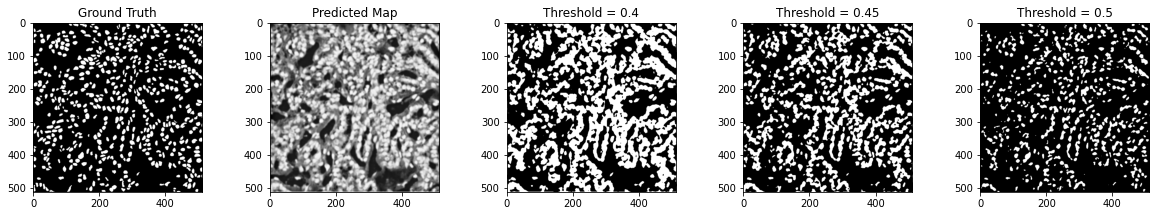

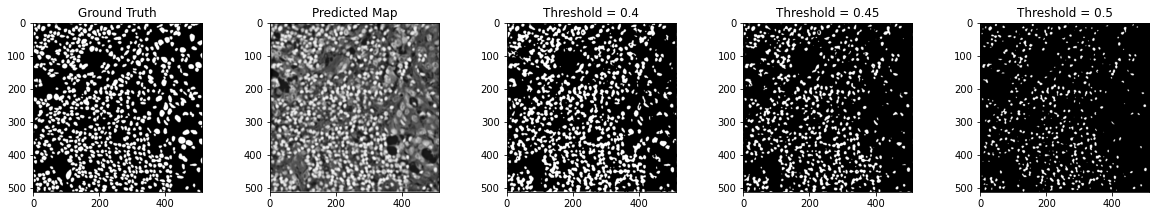

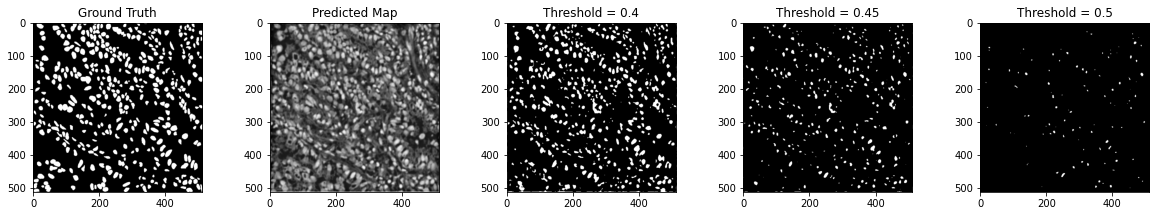

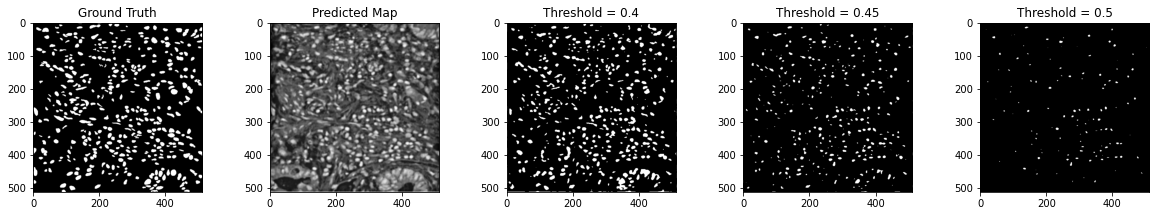

In [13]:
# Doing the same for testing images
for i in range(4):
    fig = plt.figure(figsize=(20, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 5, 1)
    ax.title.set_text('Ground Truth')
    ax.imshow(np.reshape(y_test[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 2)
    ax.title.set_text('Predicted Map')
    ax.imshow(np.reshape(result_test[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 3)
    ax.title.set_text('Threshold = 0.4')
    ax.imshow(np.reshape(to_binary(result_test[i], 0.4)*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 4)
    ax.title.set_text('Threshold = 0.45')
    ax.imshow(np.reshape(to_binary(result_test[i], 0.45)*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 5, 5)
    ax.title.set_text('Threshold = 0.5')
    ax.imshow(np.reshape(to_binary(result_test[i], 0.5)*255, (image_size, image_size)), cmap="gray")
display(Markdown("Test Images"))


# 5. Modifying the Baseline Architecture

a. Changing the number of blocks

In [14]:
# Dictionary that maps number of blocks to test scores obtained on the UNet trained with that number of blocks
test_scores_a = {
    4:test_score
}
# Training and calculating dice test scores of the predicted images
for i in [3,5,6]:
    model_a = UNet(num_blocks=i)
    model_a.compile(optimizer="adam", loss=dice_loss, metrics=[dice_score])
    model_a.fit(x=train_gen, validation_data=valid_gen, epochs=epochs)
    result_test_a = model_a.predict(x_test)
    test_scores_a[i] = calc_dice_score(y_test, result_test_a)

Epoch 1/3
4/4 [==============================] - 82s 20s/step - loss: 0.4950 - dice_score: 0.5050 - val_loss: 0.4177 - val_dice_score: 0.5823
Epoch 2/3
4/4 [==============================] - 77s 19s/step - loss: 0.4868 - dice_score: 0.5132 - val_loss: 0.4099 - val_dice_score: 0.5901
Epoch 3/3
1/1 [==============================] - 9s 9s/step
Epoch 1/3
4/4 [==============================] - 108s 27s/step - loss: 0.4898 - dice_score: 0.5102 - val_loss: 0.4132 - val_dice_score: 0.5868
Epoch 2/3
4/4 [==============================] - 104s 26s/step - loss: 0.4568 - dice_score: 0.5432 - val_loss: 0.3863 - val_dice_score: 0.6137
Epoch 3/3
1/1 [==============================] - 13s 13s/step
Epoch 1/3
4/4 [==============================] - 131s 32s/step - loss: 0.4854 - dice_score: 0.5146 - val_loss: 0.4153 - val_dice_score: 0.5847
Epoch 2/3
4/4 [==============================] - 123s 31s/step - loss: 0.4535 - dice_score: 0.5465 - val_loss: 0.3923 - val_dice_score: 0.6077
Epoch 3/3
1/1 [=======

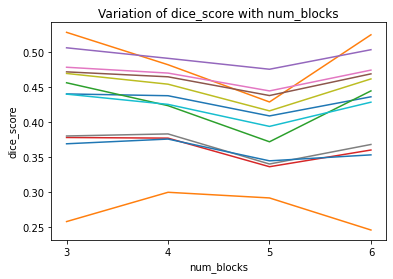

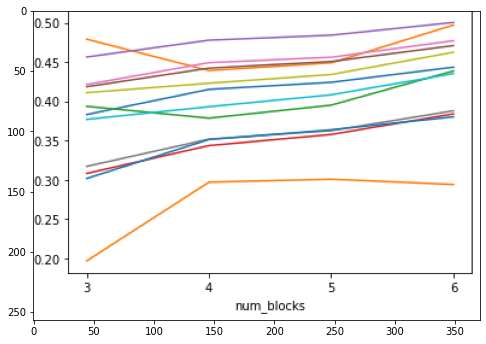

In [65]:
# Plotting the variation of dice score with increasing number of blocks for test images
plt.plot(sorted(test_scores_a.keys()), [test_scores_a[i] for i in sorted(test_scores_a.keys())])
plt.title('Variation of dice_score with num_blocks')
plt.xlabel('num_blocks')
plt.xticks(sorted(test_scores_a.keys()))
plt.ylabel('dice_score')
plt.show()

# plot obtained on a previous iteration
plot1 = plt.imread("D:/kanak/iitb/sem5/EE610/assignments/plot_test_scores_a_1.png")
plot2 = plt.figure(figsize=(8, 8))
plt.imshow(plot1)
plt.close()
display(plot2)


We infer from the above plots that the trend that dice score increases with increase in number of blocks which implies that dice loss with decrease with increase in number of blocks

b. Changing the number of filters per layer

In [16]:
# Dictionary that maps number of blocks to test scores obtained on the UNet trained with that number of filters
test_scores_b = {
    16:test_score
}
# Training and calculating dice test scores of the predicted images
for i in [8,12,20]:
    model_b = UNet(num_filts=i)
    model_b.compile(optimizer="adam", loss=dice_loss, metrics=[dice_score])
    model_b.fit(x=train_gen, validation_data=valid_gen, epochs=epochs)
    result_test_b = model_b.predict(x_test)
    test_scores_b[i] = calc_dice_score(y_test, result_test_b)


Epoch 1/3
4/4 [==============================] - 38s 9s/step - loss: 0.4922 - dice_score: 0.5078 - val_loss: 0.4190 - val_dice_score: 0.5810
Epoch 2/3
4/4 [==============================] - 33s 9s/step - loss: 0.4822 - dice_score: 0.5178 - val_loss: 0.4098 - val_dice_score: 0.5902
Epoch 3/3
1/1 [==============================] - 5s 5s/step
Epoch 1/3
4/4 [==============================] - 74s 20s/step - loss: 0.4836 - dice_score: 0.5164 - val_loss: 0.4110 - val_dice_score: 0.5890
Epoch 2/3
4/4 [==============================] - 74s 18s/step - loss: 0.4544 - dice_score: 0.5456 - val_loss: 0.4025 - val_dice_score: 0.5975
Epoch 3/3
1/1 [==============================] - 7s 7s/step
Epoch 1/3
4/4 [==============================] - 156s 37s/step - loss: 0.4965 - dice_score: 0.5035 - val_loss: 0.4189 - val_dice_score: 0.5811
Epoch 2/3
4/4 [==============================] - 131s 33s/step - loss: 0.4643 - dice_score: 0.5357 - val_loss: 0.4045 - val_dice_score: 0.5955
Epoch 3/3
1/1 [=============

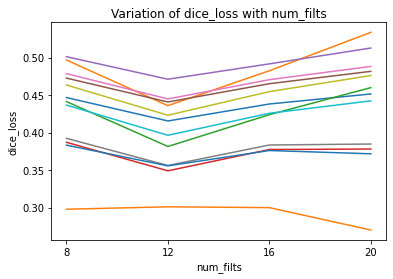

In [42]:
# Plotting the variation of dice score with increasing number of filters for test images
plt.plot(sorted(test_scores_b.keys()), [test_scores_b[i] for i in sorted(test_scores_b.keys())])
plt.title('Variation of dice_loss with num_filts')
plt.xlabel('num_filts')
plt.xticks(sorted(test_scores_b.keys()))
plt.ylabel('dice_loss')
plt.show()

c. Changing the Loss function

In [19]:
"""
MS-SSIM algorithm used is as described in the paper titled:
MULTI-SCALE STRUCTURAL SIMILARITY FOR IMAGE QUALITY ASSESSMENT
by:
Zhou Wang, Eero P. Simoncelli and Alan C. Bovik
available at:
https://www.cns.nyu.edu/pub/eero/wang03b.pdf

we choose scale M = 4

the powers need to be taken as follows:
  1. aj = bj = cj (substitute for alpha_j beta_j and gamma_j) for each Scale j (1 <= j <= M )
  2. summation( cj ) for j from 1 to M
Our Choice:
  Scale =        1,        2,        3, ....,          M-1,            M.
  Powers= 1/(2**1), 1/(2**2), 1/(2**3), ...., 1/(2**{M-1}), 1/(2**{M-1}).
since the last two are the same, they add up to 1/(2**{M-2}) and the eventually the sum will be = 1.
for our chosen scale:
powers = 1/2, 1/4, 1/8, 1/8.
"""

# low pass filtering is done convolving with a kernel (mean filtering) and
# downsampling is done by skipping every alternate pixel value in both height and width.
# This is equivalent to not caluculating the mean for the pixels at the location which would later be discarded.
# This is achieved by strides=(2, 2) which means that the averaging window will
lpf_with_down_sampling = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')


# SSIM parameters
L = 255
k1, k2 = 0.01, 0.03
c1, c2 = (k1 * L)**2, (k2 * L)**2
c3 = c2 / 2


# base SSIM fumction
def meas_ssim(x, y, powers=(1,1,1), find_l=False):
    mux = tf.math.reduce_mean(x)
    muy = tf.math.reduce_mean(y)
    sigmax = tf.math.reduce_std(x)
    sigmay = tf.math.reduce_std(y)
    sigmaxy = tf.math.reduce_mean(x * y) - sigmax * sigmay

    c = ( 2 * sigmax * sigmay + c2) / ( sigmax**2 + sigmay**2 + c2)
    s = ( sigmaxy + c3) / ( sigmax * sigmay + c3)
    
    if not find_l: # Then low pass filter and downsample
        xn = lpf_with_down_sampling(x)
        yn = lpf_with_down_sampling(y)
        return c**powers[1] * s**powers[2], xn, yn
    else:
        l = ( 2 * mux * muy + c1) / ( mux**2 + muy**2 + c1)
        return l**powers[0] * c**powers[1] * s**powers[2], None, None


# MS-SSIM function
def MS_SSIM(x, y, M=4):
    xn, yn = tf.expand_dims(x, axis=0), tf.expand_dims(y, axis=0)
    ms_ssim_val = 1

    for Scale in range(1, M+1):

        current_scale_ssim, xn, yn = meas_ssim(
            xn,
            yn,
            powers = 3 * [ 1 / ( 2**Scale ) ] if Scale < M else 3 * [ 1 / ( 2**(Scale - 1) ) ],
            find_l = Scale == M # Need the L part of SSIM for the last Scale too...
        )

        ms_ssim_val *= current_scale_ssim

    return ms_ssim_val


"""
the loss function to be used for training the model:
for a good image, dice loss should be low and ms-ssim should be high
therefore, we can either take the loss (which will be minimized during the training)
to be the average of the dice loss and ( 1 - ms-ssim )
[since this makes ms-ssim as a loss fn. (Technically, as it needs to be reduced)]
or by having a trade off parameter ( a weight ).
"""
# Defining a custom loss function which is a linear combination of dice loss of MS_SSIM function
def custom_loss_function(y_true, y_pred):

    loss_val = 0.7934 * dice_loss(y_true, y_pred) + 0.2066 * ( 1 - MS_SSIM(y_true, y_pred) )
    
    return loss_val

# Custom metric
def custom_metric(y_true, y_pred):
    return 1 - custom_loss_function(y_true, y_pred)

In [23]:
# Training the UNet model with custom loss function defined above
model_c = UNet()
model_c.compile(optimizer="adam", loss=custom_loss_function, metrics=[custom_metric])
model_c.fit(x=train_gen, validation_data=valid_gen, epochs=epochs)
result_test_c = model_c.predict(x_test)

Epoch 1/3
4/4 [==============================] - 67s 17s/step - loss: 0.3811 - custom_metric: 0.6189 - val_loss: 0.3230 - val_custom_metric: 0.6770
Epoch 2/3
4/4 [==============================] - 54s 13s/step - loss: 0.3641 - custom_metric: 0.6359 - val_loss: 0.3322 - val_custom_metric: 0.6678
Epoch 3/3
1/1 [==============================] - 5s 5s/step


Test Images

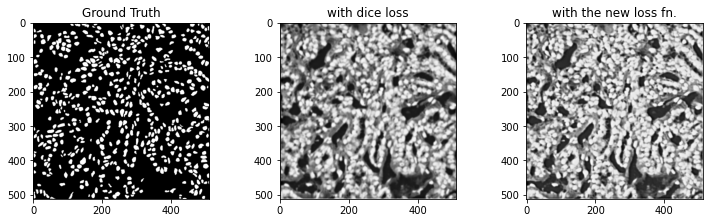

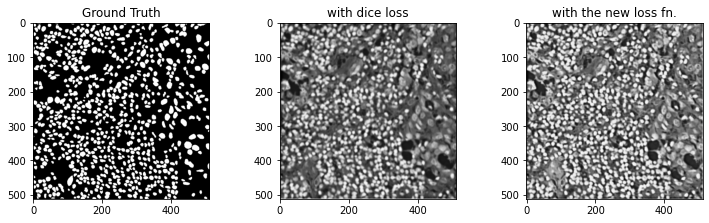

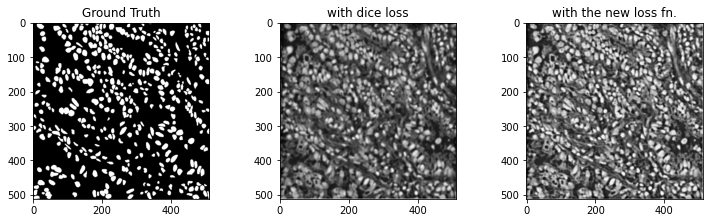

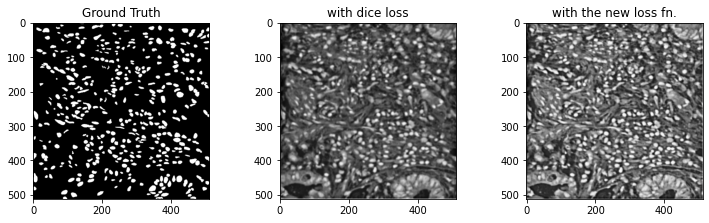

In [24]:
# Plotting the original images, image with dice loss and image with custom loss function parallely to find 
# which loss function suits the best for prediction
for i in range(4):
    fig = plt.figure(figsize=(12, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 3, 1)
    ax.title.set_text('Ground Truth')
    ax.imshow(np.reshape(y_test[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 2)
    ax.title.set_text('with dice loss')
    ax.imshow(np.reshape(result_test[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.title.set_text('with the new loss fn.')
    ax.imshow(np.reshape(result_test_c[i]*255, (image_size, image_size)), cmap="gray")
display(Markdown("Test Images"))

From the above plot we find that nuclues regions are brighter in images prediction by custom loss function than those predicted by dice loss only

In [36]:
test_scores_c = calc_dice_score(y_test, result_test_c)
print(
    f'Avg. test images dice score when trained with only dice loss : {np.mean(test_score)}',
    f'Avg. test images dice score when trained with the custom loss : {np.mean(test_scores_c)}',
    sep='\n'
    )
    # Printing the average dice score of predicted images via dice loss and custom loss respectively

Avg. test images dice score when trained with only dice loss : 0.42418629971988525
Avg. test images dice score when trained with the custom loss : 0.4280141085765607


We find that the dice score of images predicted by custom loss is more than those predicted by only dice loss

Which displays that the custom loss function is better compared to dice loss function 

# 6. Watershed Segmentation

C:\Users\kanak\AppData\Local\Temp/ipykernel_13000/492686301.py:25: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=thresholds[i], labels=thresh)


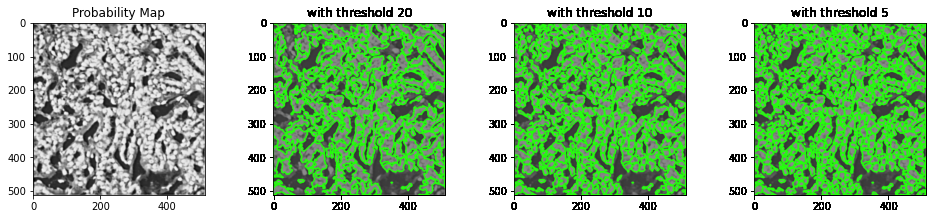

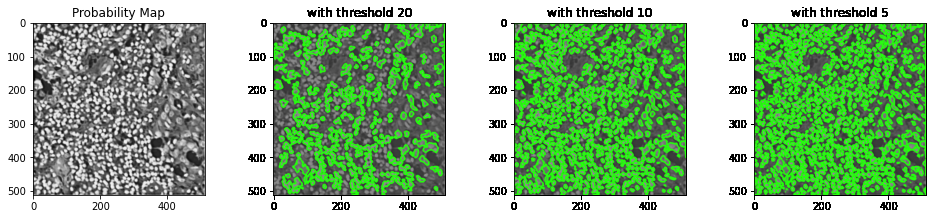

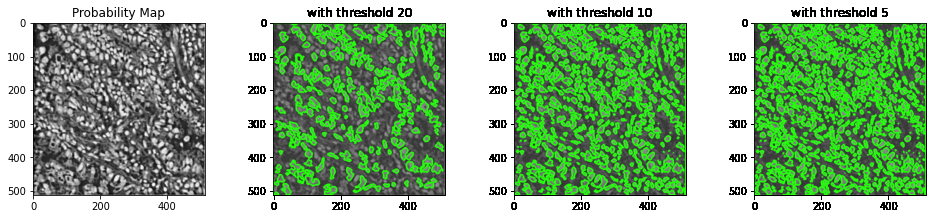

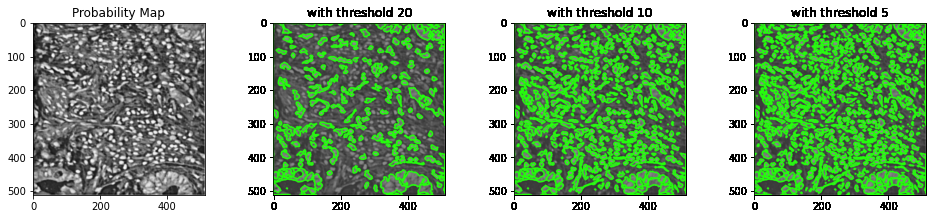

In [92]:
# We are using probability maps predicted by custom loss function 
for image in result_test_c[:4]:
    # The following code has been copied from: https://stackoverflow.com/questions/57813137/how-to-use-watershed-segmentation-in-opencv-python

    # Loading image, converting to gray scale, and using Otsu's threshold
    cv2.imwrite('_.jpg', image*255)
    image = cv2.imread('_.jpg', 1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Computing Euclidean distance from every binary pixel
    # to the nearest zero pixel then finding peaks
    distance_map = ndimage.distance_transform_edt(thresh)
    
    fig = plt.figure(figsize=(16, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 4, 1)
    ax.title.set_text('Probability Map')
    ax.imshow(gray, cmap="gray")

    # Varying the thresholds for three different values
    thresholds = [20, 10, 5]
    for i in range(len(thresholds)):
        local_max = peak_local_max(distance_map, indices=False, min_distance=thresholds[i], labels=thresh)

        # Performing connected component analysis then Watershedding
        markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
        labels = watershed(-distance_map, markers, mask=thresh)

        # Iterating through the unique labels
        for label in np.unique(labels):
            if label == 0:
                continue

            # Creating a mask
            mask = np.zeros(gray.shape, dtype="uint8")
            mask[labels == label] = 255

            # Finding contours and determining contour area
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]
            c = max(cnts, key=cv2.contourArea)
            cv2.drawContours(image, [c], -1, (36,255,12), 4)

            ax = fig.add_subplot(1, 4, i+2)
            ax.title.set_text(f'with threshold {thresholds[i]}')
            ax.imshow(image, cmap="gray")

        # Displaying the images
